In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf
import itertools
from itertools import product
import warnings
warnings.filterwarnings('ignore')  # 关闭所有警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [2]:
# 读取 Excel 文件
file_path = 'data.xlsx'

# 查看文件内所有sheet名，确认需要读取的sheet
xls = pd.ExcelFile(file_path)
print("Sheet names:", xls.sheet_names)

Sheet names: ['收盘价', '自由流通换手率']


In [3]:
# 读取 sheet1
df = pd.read_excel(file_path, sheet_name='收盘价')

In [4]:
# 将第一列（日期列）重命名为 'date'
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# 将 'date' 转换为 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 设置为 index
df = df.set_index('date')

# 检查结果
print(df.head())
print(df.index)

               50收益  中证1000全收益     800收益
date                                    
2005-01-04  835.130    989.984  983.8953
2005-01-05  839.529   1013.583  995.5764
2005-01-06  830.513   1005.466  986.2162
2005-01-07  831.641   1011.740  987.6929
2005-01-10  841.102   1023.638  997.1864
DatetimeIndex(['2005-01-04', '2005-01-05', '2005-01-06', '2005-01-07',
               '2005-01-10', '2005-01-11', '2005-01-12', '2005-01-13',
               '2005-01-14', '2005-01-17',
               ...
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27'],
              dtype='datetime64[ns]', name='date', length=4974, freq=None)


## 动量 + 反转 + macd 市场区分策略

In [5]:
def momentum_strategy_monthly(df, window=10, threshold=0, min_large_weight=0.5):
    """
    纯动量大小盘切换策略（月度调仓版本）

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - window: int，计算动量的窗口期
    - threshold: float，小盘相对大盘收益率超过阈值才切换
    - min_large_weight: float，不满足动量条件时，大盘的最小配置比例

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，二者加总为1
    """

    # === 1) 计算动量 ===
    r_50 = df['50收益'].pct_change(periods=window)
    r_1000 = df['中证1000全收益'].pct_change(periods=window)

    # === 2) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 3) 初始化仓位 ===
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    # 初始默认仓位
    current_pos_50 = min_large_weight
    current_pos_1000 = 1 - min_large_weight

    # === 4) 根据信号更新仓位 ===
    for date in df.index:
        if date in month_end_dates:
            if (r_1000.loc[date] > r_50.loc[date] + threshold):
                current_pos_50 = 0
                current_pos_1000 = 1
            else:
                current_pos_50 = 1
                current_pos_1000 = 0

            # 归一化
            total = current_pos_50 + current_pos_1000
            current_pos_50 /= total
            current_pos_1000 /= total

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

In [6]:
def reversal_strategy_monthly(df, window=30, min_large_weight=0.9):
    """
    纯反转大小盘切换策略（月度调仓版）

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - window: int，计算反转信号的窗口期
    - min_large_weight: float，大盘最小配置比例

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，二者加总为1
    """

    # === 1) 计算过去window日收益率 ===
    r_50 = df['50收益'].pct_change(periods=window)
    r_1000 = df['中证1000全收益'].pct_change(periods=window)

    # === 2) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 3) 初始化仓位 ===
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    # 初始默认仓位
    current_pos_50 = min_large_weight
    current_pos_1000 = 1 - min_large_weight

    # === 4) 根据信号更新仓位 ===
    for date in df.index:
        if date in month_end_dates:
            if (r_1000.loc[date] < r_50.loc[date]):  # 小盘近期弱 ➔ 买入小盘
                current_pos_50 = 0
                current_pos_1000 = 1
            else:  # 小盘近期强 ➔ 买入大盘
                current_pos_50 = 1
                current_pos_1000 = 0

            # 归一化
            total = current_pos_50 + current_pos_1000
            current_pos_50 /= total
            current_pos_1000 /= total

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

In [7]:
def macd_momentum_strategy_monthly(df, fast_window=20, slow_window=26, signal_window=5, min_large_weight=0.7):
    """
    MACD 趋势动量大小盘切换策略（月度调仓版）

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - fast_window: int，短期EMA窗口
    - slow_window: int，长期EMA窗口
    - signal_window: int，MACD Signal线窗口
    - min_large_weight: float，大盘最小配置比例

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列
    """

    # === 1) 计算 MACD 指标 ===
    price = df['中证1000全收益']
    
    ema_fast = price.ewm(span=fast_window, adjust=False).mean()
    ema_slow = price.ewm(span=slow_window, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    
    # === 2) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 3) 初始化仓位 ===
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    # 初始默认仓位
    current_pos_50 = min_large_weight
    current_pos_1000 = 1 - min_large_weight

    # === 4) 根据信号更新仓位 ===
    for date in df.index:
        if date in month_end_dates:
            if macd_line.loc[date] > signal_line.loc[date]:
                # 小盘趋势强，买入小盘
                current_pos_50 = 0
                current_pos_1000 = 1
            else:
                # 大盘趋势强，买入大盘
                current_pos_50 = 1
                current_pos_1000 = 0

            # 归一化
            total = current_pos_50 + current_pos_1000
            current_pos_50 /= total
            current_pos_1000 /= total

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

In [46]:
def market_state_detection(df, short_ma=20, long_ma=60, slope_threshold_trend=0.005, slope_threshold_short=0.005, gap_threshold=0.02):
    """
    使用均线斜率 + 均线差距判断市场状态
    返回 Series: 'Momentum', 'MACD', 'Reversal'
    """
    df['MA_short'] = df['800收益'].rolling(short_ma).mean()
    df['MA_long'] = df['800收益'].rolling(long_ma).mean()
    
    # 计算斜率
    df['slope_short'] = df['MA_short'].diff(short_ma) / short_ma / df['MA_short']
    df['slope_long'] = df['MA_long'].diff(long_ma) / long_ma / df['MA_long']
    
    # 均线差距
    df['gap'] = (df['MA_short'] - df['MA_long']) / df['MA_long']
    
    # 判断市场状态
    state = []
    for i in range(len(df)):
        slope_l = df['slope_long'].iloc[i]
        slope_s = df['slope_short'].iloc[i]
        gap = df['gap'].iloc[i]
        
        if slope_l > slope_threshold_trend and abs(gap) > gap_threshold:
            state.append('Momentum')
        elif slope_s > slope_threshold_short:
            state.append('MACD')
        else:
            state.append('Reversal')
    
    df['Market_State'] = state
    return df['Market_State']


In [26]:
def combined_strategy(df, market_state_series, momentum_params, macd_params, reversal_params):
    """
    根据 market_state_series 决定调用哪个策略
    返回 position_df
    """
    # 初始化仓位
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')
    
    # 计算各策略信号
    pos_mom = momentum_strategy_monthly(df, **momentum_params)
    pos_macd = macd_momentum_strategy_monthly(df, **macd_params)
    pos_rev = reversal_strategy_monthly(df, **reversal_params)
    
    for date in df.index:
        state = market_state_series.loc[date]
        if state == 'Momentum':
            position_50.loc[date] = pos_mom.loc[date, 'position_50']
            position_1000.loc[date] = pos_mom.loc[date, 'position_1000']
        elif state == 'MACD':
            position_50.loc[date] = pos_macd.loc[date, 'position_50']
            position_1000.loc[date] = pos_macd.loc[date, 'position_1000']
        else:
            position_50.loc[date] = pos_rev.loc[date, 'position_50']
            position_1000.loc[date] = pos_rev.loc[date, 'position_1000']
    
    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)
    
    return position_df


### 回测

In [47]:
# 生成市场状态序列
market_state_series = market_state_detection(
    df,
    short_ma=20,
    long_ma=60,
    slope_threshold_trend=0.0,
    slope_threshold_short=0.005,
    gap_threshold=0.02
)

In [43]:
# Momentum strategy 参数
momentum_params = {
    'window': 10,
    'threshold': 0.0,
    'min_large_weight': 0.5
}

# MACD strategy 参数
macd_params = {
    'fast_window': 20,
    'slow_window': 26,
    'signal_window': 5,
    'min_large_weight': 0.7
}

# Reversal strategy 参数
reversal_params = {
    'window': 30,
    'min_large_weight': 0.9
}

In [48]:
# 获取策略每日仓位
position_df = combined_strategy(df,market_state_series,momentum_params, macd_params, reversal_params)

# =============================
# 计算每日组合收益率
# =============================
returns_50 = df['50收益'].pct_change()
returns_1000 = df['中证1000全收益'].pct_change()
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# =============================
# 计算净值与超额净值曲线
# =============================
portfolio_nav = (1 + portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# =============================
# 计算回测指标
# =============================
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# =============================
# 输出结果
# =============================
print(f"【回测指标】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")

【回测指标】
年化收益率: 18.08%
年化波动率: 28.02%
夏普比率: 0.65
最大回撤: -65.53%
Calmar Ratio: 0.28


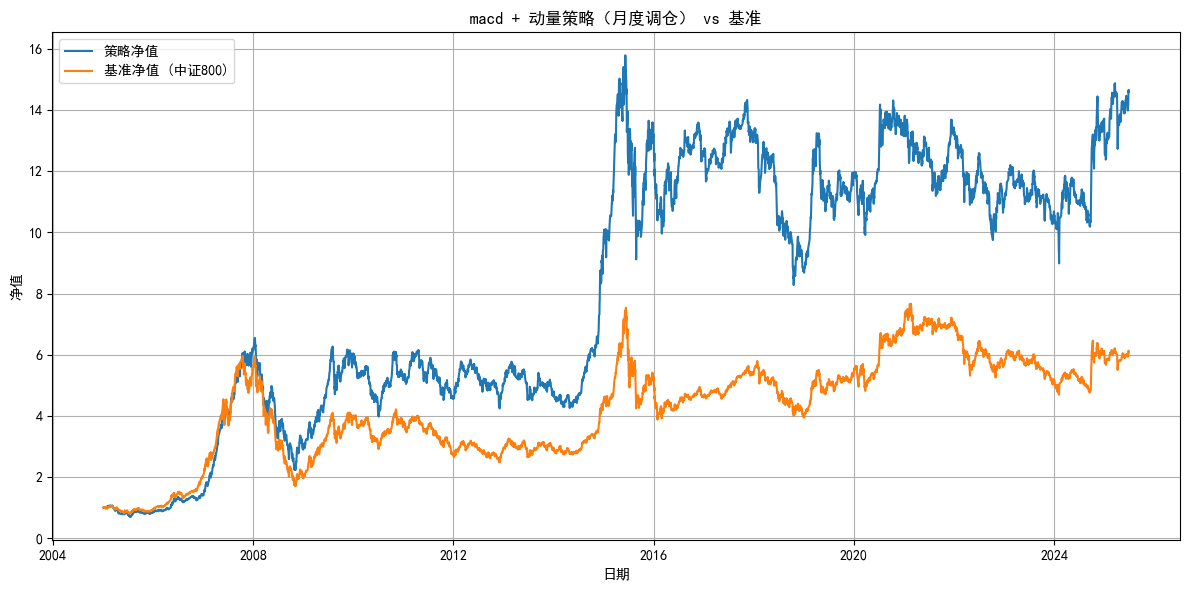

In [30]:
# 绘制净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.title('macd + 动量策略（月度调仓） vs 基准')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

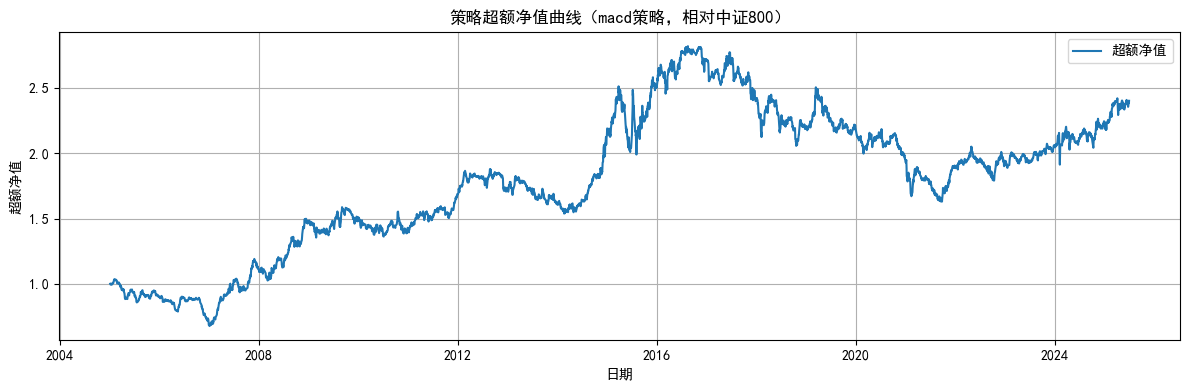

In [31]:
# 绘制超额净值曲线
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('策略超额净值曲线（macd策略，相对中证800）')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 参数调优

In [21]:
# =======================
# 数据切分
# =======================

split_index_train = int(len(df) * 0.65)
split_index_val = int(len(df) * 0.8)

df_train = df.iloc[:split_index_train]
df_val = df.iloc[split_index_train:split_index_val]
df_test = df.iloc[split_index_val:]

In [23]:
# ========================
# 定义参数搜索空间
# ========================

short_ma_range = [10, 20]
long_ma_range = [50, 60]
slope_threshold_trend_range = [0.005, 0.01]
slope_threshold_short_range = [0.002, 0.005]
gap_threshold_range = [0.01, 0.02]

# ========================
# 固定三策略最优参数
# （替换为之前的最优参数）
# ========================

momentum_params = {
    'window': 10,
    'threshold': 0.0,
    'min_large_weight': 0.5
}

macd_params = {
    'fast_window': 12,
    'slow_window': 26,
    'signal_window': 5,
    'min_large_weight': 0.7
}

reversal_params = {
    'window': 30,
    'min_large_weight': 0.9
}

# ========================
# 参数搜索
# ========================

results = []

param_combinations = itertools.product(
    short_ma_range,
    long_ma_range,
    slope_threshold_trend_range,
    slope_threshold_short_range,
    gap_threshold_range
)

for params in param_combinations:
    short_ma, long_ma, slope_threshold_trend, slope_threshold_short, gap_threshold = params

    # ================
    # 生成 market_state_series
    # ================
    market_state_series = market_state_detection(
        df_train,
        short_ma=short_ma,
        long_ma=long_ma,
        slope_threshold_trend=slope_threshold_trend,
        slope_threshold_short=slope_threshold_short,
        gap_threshold=gap_threshold
    )

    # ================
    # 调用组合策略
    # ================
    position_df = combined_strategy(
        df_train,
        market_state_series,
        momentum_params,
        macd_params,
        reversal_params
    )

    # ================
    # 计算组合收益
    # ================
    returns_50 = df_train['50收益'].pct_change()
    returns_1000 = df_train['中证1000全收益'].pct_change()
    portfolio_returns = (position_df['position_50'] * returns_50 +
                         position_df['position_1000'] * returns_1000).fillna(0)

    portfolio_nav = (1 + portfolio_returns).cumprod()

    # ================
    # 计算回测指标
    # ================
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)

    # ================
    # 保存结果
    # ================
    results.append({
        'short_ma': short_ma,
        'long_ma': long_ma,
        'slope_threshold_trend': slope_threshold_trend,
        'slope_threshold_short': slope_threshold_short,
        'gap_threshold': gap_threshold,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# ========================
# 输出Top 10
# ========================

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))

【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
    short_ma  long_ma  slope_threshold_trend  slope_threshold_short  \
27        20       60                  0.005                  0.005   
26        20       60                  0.005                  0.005   
19        20       50                  0.005                  0.005   
18        20       50                  0.005                  0.005   
25        20       60                  0.005                  0.002   
24        20       60                  0.005                  0.002   
16        20       50                  0.005                  0.002   
17        20       50                  0.005                  0.002   
30        20       60                  0.010                  0.005   
23        20       50                  0.010                  0.005   

    gap_threshold  annual_return  annual_vol  sharpe_ratio  max_drawdown  \
27           0.02       0.192088    0.303337      0.633249     -0.659789   
26           0.01       0.1920

### 测试集检验

In [32]:
momentum_params = {
    'window': 10,
    'threshold': 0.005,
    'min_large_weight': 0.5
}

macd_params = {
    'fast_window': 12,
    'slow_window': 26,
    'signal_window': 9,
    'min_large_weight': 0.7
}

reversal_params = {
    'window': 20,
    'min_large_weight': 0.8
}

In [34]:
best_params = results_df_sorted.iloc[0]
best_params

short_ma                 20.000000
long_ma                  60.000000
slope_threshold_trend     0.005000
slope_threshold_short     0.005000
gap_threshold             0.020000
annual_return             0.192088
annual_vol                0.303337
sharpe_ratio              0.633249
max_drawdown             -0.659789
calmar_ratio              0.291135
Name: 27, dtype: float64

In [35]:
# ========================
# 选取最优 market_state_detection 参数
# ========================

best_params = results_df_sorted.iloc[0]

# ========================
# 生成 market_state_series（验证集 / 测试集）
# ========================

market_state_series_val = market_state_detection(
    df_val,
    short_ma=int(best_params['short_ma']),
    long_ma=int(best_params['long_ma']),
    slope_threshold_trend=int(best_params['slope_threshold_trend']),
    slope_threshold_short=int(best_params['slope_threshold_short']),
    gap_threshold=int(best_params['gap_threshold'])
)

# ========================
# 调用组合策略
# ========================

position_df_val = combined_strategy(
    df_val,
    market_state_series_val,
    momentum_params,
    macd_params,
    reversal_params
)

# ========================
# 计算组合收益
# ========================

returns_50_val = df_val['50收益'].pct_change()
returns_1000_val = df_val['中证1000全收益'].pct_change()
portfolio_returns_val = (position_df_val['position_50'] * returns_50_val +
                         position_df_val['position_1000'] * returns_1000_val).fillna(0)

portfolio_nav_val = (1 + portfolio_returns_val).cumprod()

# ========================
# 计算回测指标
# ========================

annual_return_val = portfolio_nav_val.iloc[-1] ** (252 / len(portfolio_nav_val)) - 1
annual_vol_val = portfolio_returns_val.std() * np.sqrt(252)
sharpe_ratio_val = annual_return_val / annual_vol_val
max_drawdown_val = (portfolio_nav_val / portfolio_nav_val.cummax() - 1).min()
calmar_ratio_val = annual_return_val / abs(max_drawdown_val)

# ========================
# 输出验证集结果
# ========================

print("\n【验证集（测试集1）表现】")
print(f"年化收益率: {annual_return_val:.2%}")
print(f"年化波动率: {annual_vol_val:.2%}")
print(f"夏普比率: {sharpe_ratio_val:.2f}")
print(f"最大回撤: {max_drawdown_val:.2%}")
print(f"Calmar Ratio: {calmar_ratio_val:.2f}")


【验证集（测试集1）表现】
年化收益率: 4.83%
年化波动率: 22.85%
夏普比率: 0.21
最大回撤: -36.60%
Calmar Ratio: 0.13


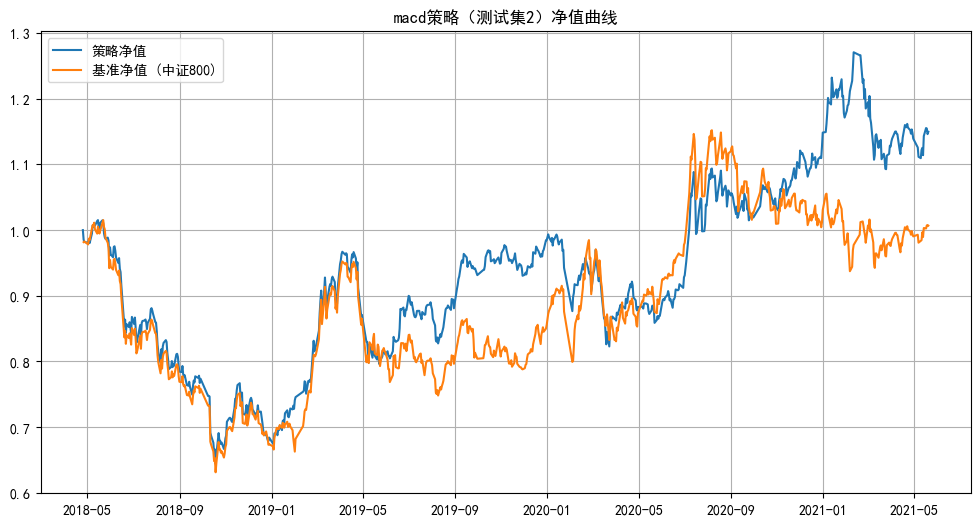

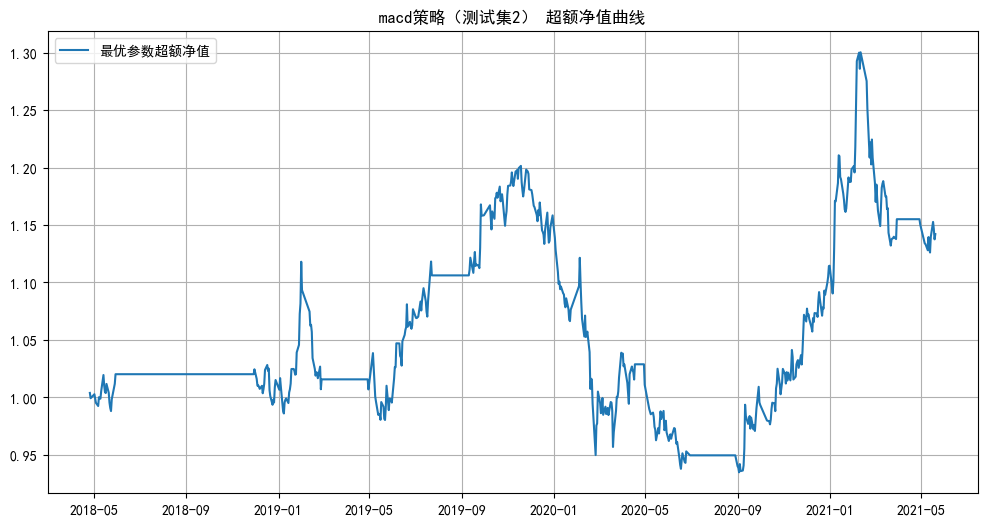

In [36]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_val = (1 + returns_1000_val).cumprod()

# 计算超额净值曲线
excess_nav_val = portfolio_nav_val / benchmark_nav_val


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_val.index, portfolio_nav_val, label='策略净值')
plt.plot(benchmark_nav_val.index, benchmark_nav_val, label='基准净值 (中证800)')
plt.title('macd策略（测试集2）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_val.index, excess_nav_val, label='最优参数超额净值')
plt.title('macd策略（测试集2） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# ========================
# 生成 market_state_series （测试集2）
# ========================
market_state_series_test = market_state_detection(
    df_test,
    short_ma=int(best_params['short_ma']),
    long_ma=int(best_params['long_ma']),
    slope_threshold_trend=best_params['slope_threshold_trend'],
    slope_threshold_short=best_params['slope_threshold_short'],
    gap_threshold=best_params['gap_threshold']
)

# ========================
# 调用组合策略
# ========================
# 确保 market_state_series_test index 与 df_test index 对齐
market_state_series_test = market_state_series_test.reindex(df_test.index, method='ffill')

position_df_test = combined_strategy(
    df_test,
    market_state_series_test,
    momentum_params,
    macd_params,
    reversal_params
)

# ========================
# 计算组合收益
# ========================
returns_50_test = df_test['50收益'].pct_change()
returns_1000_test = df_test['中证1000全收益'].pct_change()
portfolio_returns_test = (position_df_test['position_50'] * returns_50_test +
                          position_df_test['position_1000'] * returns_1000_test).fillna(0)

portfolio_nav_test = (1 + portfolio_returns_test).cumprod()

# ========================
# 计算回测指标
# ========================
annual_return_test = portfolio_nav_test.iloc[-1] ** (252 / len(portfolio_nav_test)) - 1
annual_vol_test = portfolio_returns_test.std() * np.sqrt(252)
sharpe_ratio_test = annual_return_test / annual_vol_test
max_drawdown_test = (portfolio_nav_test / portfolio_nav_test.cummax() - 1).min()
calmar_ratio_test = annual_return_test / abs(max_drawdown_test)

# ========================
# 输出测试集2结果
# ========================
print("\n【测试集2（最终测试集）表现】")
print(f"年化收益率: {annual_return_test:.2%}")
print(f"年化波动率: {annual_vol_test:.2%}")
print(f"夏普比率: {sharpe_ratio_test:.2f}")
print(f"最大回撤: {max_drawdown_test:.2%}")
print(f"Calmar Ratio: {calmar_ratio_test:.2f}")


【测试集2（最终测试集）表现】
年化收益率: -0.37%
年化波动率: 23.17%
夏普比率: -0.02
最大回撤: -40.27%
Calmar Ratio: -0.01


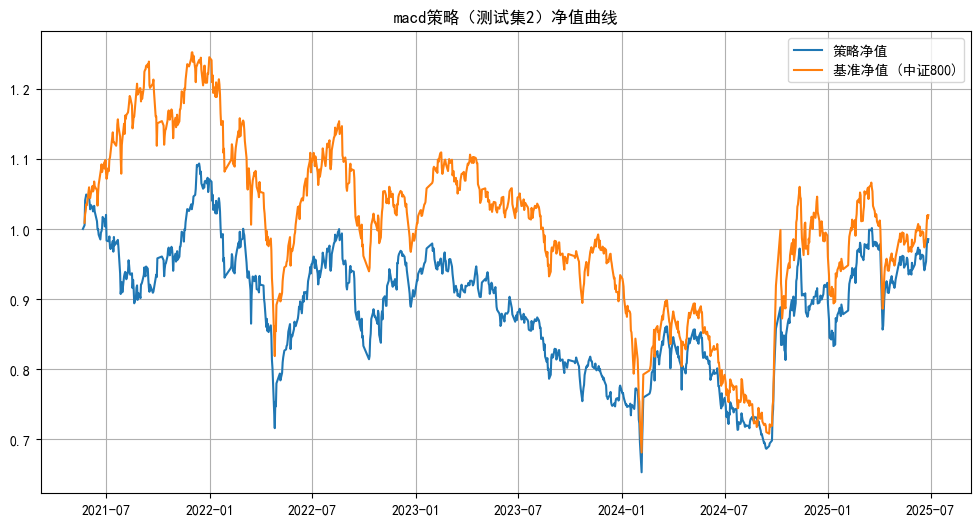

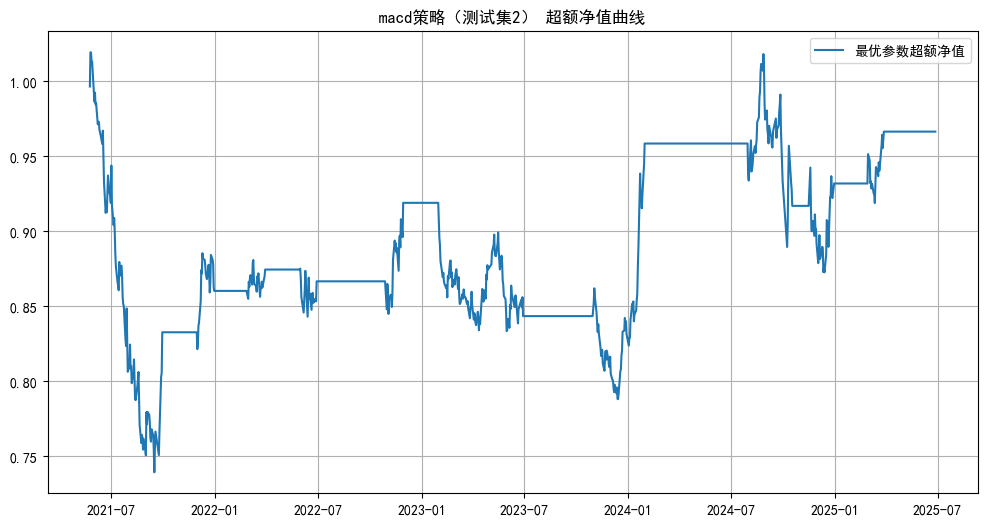

In [39]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_test = (1 + returns_1000_test).cumprod()

# 计算超额净值曲线
excess_nav_test = portfolio_nav_test / benchmark_nav_test


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_test.index, portfolio_nav_test, label='策略净值')
plt.plot(benchmark_nav_test.index, benchmark_nav_test, label='基准净值 (中证800)')
plt.title('macd策略（测试集2）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_test.index, excess_nav_test, label='最优参数超额净值')
plt.title('macd策略（测试集2） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()